# Task 3: PyMongo

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from pymongo import MongoClient
import matplotlib.pyplot as plt
from de_classes.mongo_classes.utils_mongo import UtilsMongo
from de_classes.mongo_classes.mongo_query import MongoQuery
from de_classes.utility_classes.spark_manager import SparkManager
from de_classes.utility_classes.input_country_manager import InputCountryManager
load_dotenv()

True

In [2]:
mongo_uri = os.getenv("MONGO_URI")
mongo_db = os.getenv("MONGO_DB")

client = MongoClient(mongo_uri)
db = client[mongo_db]

with SparkManager(app_name = "MONGO APP") as manager:
    mongo_spark = manager.spark
    utils = UtilsMongo(db, mongo_spark)
    utils.load_all(overwrite=True)  

25/08/29 19:41:42 WARN Utils: Your hostname, fz.localdomain resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/29 19:41:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/29 19:41:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[PATHS] {'countries': 'hdfs://localhost:9000/user/student/data_store/meta_data/de_countries.csv', 'cities': 'hdfs://localhost:9000/user/student/data_store/meta_data/de_cities.csv', 'weathers': 'hdfs://localhost:9000/user/student/data_store/processed_data/cleanned_data/cleaned_weather_parquet', 'carbons': 'hdfs://localhost:9000/user/student/data_store/processed_data/cleanned_data/cleaned_co2_parquet'}

[LOAD] countries


[OVERWRITE] Cleared 'countries'
[INSERT] 8 docs -> 'countries' (final)

[LOAD] cities
[OVERWRITE] Cleared 'cities'
[INSERT] 235 docs -> 'cities' (final)

[LOAD] weathers


[OVERWRITE] Cleared 'weathers'


[INSERT] 1000 docs -> 'weathers'
[INSERT] 2000 docs -> 'weathers'
[INSERT] 3000 docs -> 'weathers'
[INSERT] 4000 docs -> 'weathers'
[INSERT] 5000 docs -> 'weathers'
[INSERT] 6000 docs -> 'weathers'
[INSERT] 7000 docs -> 'weathers'
[INSERT] 8000 docs -> 'weathers'
[INSERT] 9000 docs -> 'weathers'
[INSERT] 10000 docs -> 'weathers'
[INSERT] 11000 docs -> 'weathers'
[INSERT] 12000 docs -> 'weathers'
[INSERT] 13000 docs -> 'weathers'
[INSERT] 14000 docs -> 'weathers'
[INSERT] 15000 docs -> 'weathers'
[INSERT] 16000 docs -> 'weathers'
[INSERT] 17000 docs -> 'weathers'
[INSERT] 18000 docs -> 'weathers'
[INSERT] 19000 docs -> 'weathers'
[INSERT] 20000 docs -> 'weathers'
[INSERT] 21000 docs -> 'weathers'
[INSERT] 22000 docs -> 'weathers'
[INSERT] 23000 docs -> 'weathers'
[INSERT] 24000 docs -> 'weathers'
[INSERT] 25000 docs -> 'weathers'
[INSERT] 26000 docs -> 'weathers'
[INSERT] 27000 docs -> 'weathers'
[INSERT] 28000 docs -> 'weathers'
[INSERT] 29000 docs -> 'weathers'
[INSERT] 30000 docs -> 

[OVERWRITE] Cleared 'carbons'
[INSERT] 1000 docs -> 'carbons'
[INSERT] 2000 docs -> 'carbons'
[INSERT] 3000 docs -> 'carbons'
[INSERT] 4000 docs -> 'carbons'
[INSERT] 4608 docs -> 'carbons' (final)


## Query 1: Top CO₂ Emission Day per Country with Hottest Cities


Available countries:
 0 - All countries
 1 - China
 2 - France
 3 - Germany
 4 - India
 5 - Japan
 6 - Russia
 7 - United Kingdom
 8 - United States



Enter your choice (0 for all):  5



Top Emission Day in Japan:
2021-12-01 | Japan | Total CO₂: 4.1106
Hottest Cities that day:
   - Naha | Max Temp: 19.2°C
   - Ōsaka | Max Temp: 15.4°C
   - Nagoya | Max Temp: 15.4°C
   - Gifu | Max Temp: 13.5°C
   - Tomakomai | Max Temp: 13.2°C


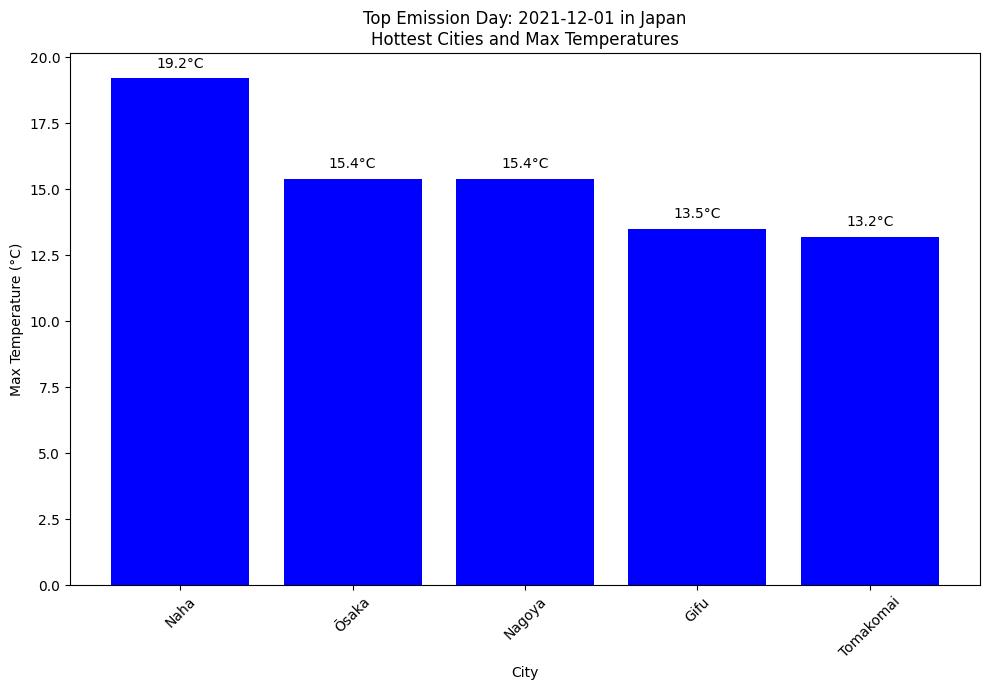

In [3]:
mongo_query = MongoQuery(db)
available_countries = mongo_query.list_countries()

country = InputCountryManager.get_country(available_countries)

results = MongoQuery.query_top_emission_day_with_cities(db, country=country)

print(f"\nTop Emission Day {'in ' + country if country else 'globally'}:")

if results:
    r = results[0]
    print(f"{r['date']} | {r['country']} | Total CO₂: {r['total_emission']:.4f}")
    print("Hottest Cities that day:")
    for city in r["hottest_cities"]:
        print(f"   - {city['_id']} | Max Temp: {city['max_temp']}°C")

    cities = [city['_id'] for city in r["hottest_cities"]]
    temps = [city['max_temp'] for city in r["hottest_cities"]]

    plt.figure(figsize=(10, 7))
    bars = plt.bar(cities, temps, color='blue')
    plt.title(f"Top Emission Day: {r['date']} in {r['country']}\nHottest Cities and Max Temperatures")
    plt.xlabel("City")
    plt.ylabel("Max Temperature (°C)")
    plt.xticks(rotation=45)

    for bar, temp in zip(bars, temps):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.3, f'{temp}°C', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

else:
    print("No records found with given filters.")

## Query 2: Extreme Weather Impact on CO₂ Emissions

In [4]:
mongo_uri = os.getenv("MONGO_URI")
mongo_db = os.getenv("MONGO_DB")

client = MongoClient(mongo_uri)
db = client[mongo_db]
mongo_query = MongoQuery(db)
results = list(mongo_query.query_emission_vs_extreme_weather(
    temp_threshold=35.0,
    risk_levels=["SEVERE"],  
    limit=5
))

df = pd.DataFrame([
    {
        "Country": r["_id"]["country"],
        "Date": r["_id"]["date"],
        "Extreme Events": r["extreme_events"],
        "Max Temp (°C)": r["max_temp"],
        "Avg Risk Score": round(r["avg_risk"], 2),
        "Total Emission (MtCO₂/day)": round(r["total_emission"], 4)
    }
    for r in results
])

print("\n=== Emissions Co2 vs Extreme Weather ===")
display(df.head(len(df)))


=== Emissions Co2 vs Extreme Weather ===


,Country,Date,Extreme Events,Max Temp (°C),Avg Risk Score,Total Emission (MtCO₂/day)
0,China,2022-07-01,4,38.5,1.68,36.5038
1,China,2022-06-01,1,36.0,1.80,36.4092
2,China,2022-07-08,9,39.1,1.93,33.9029
3,China,2022-06-08,1,35.1,2.00,33.8539
4,China,2022-06-12,2,36.4,1.65,33.2545


In [5]:
client.close()